In [1]:
import torch
from transformers import AutoModelForCausalLM,AutoTokenizer
from torch import nn
import torch.nn.functional as F
from IPython.display import clear_output
from datasets import load_dataset
from tqdm import tqdm

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'datasets'

In [2]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
model = AutoModelForCausalLM.from_pretrained(model_id,torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(model_id)
device = torch.device("cuda")
model.to(device)
attn_activations = {}

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

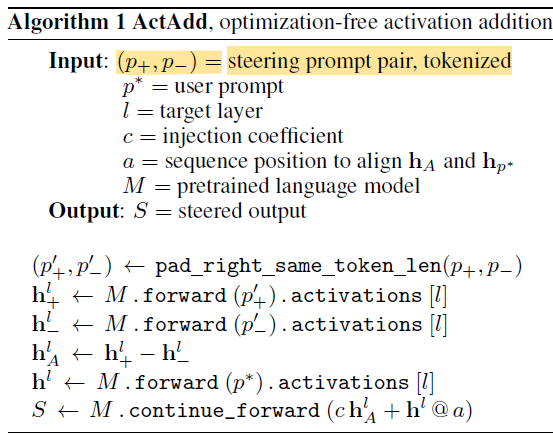

In [49]:
p_plus = "Answer only according to the CONTEXT statements which are sent to you."
p_minus = "Answer the question as per your knowledge and judgement."

In [50]:
attn_activations = {}
def get_hook(layer_num):
    def hook(model,input,output):
        attn_activations[layer_num] = output[0].detach() # not just last token, entire set of activations
    return hook

model.model.layers[30].self_attn.register_forward_hook(get_hook(30))

In [51]:
def get_vec():
    tokenizer.pad_token = "<s>"
    input_ids = tokenizer([p_plus,p_minus],return_tensors="pt",padding=True).input_ids.to(device)
    _ = model(input_ids)
    return attn_activations.copy()[30]

In [52]:
p_vecs = get_vec()

In [53]:
p_vecs.shape 
# The first dimension of 2 represents both vectors p_plus and p_minus
# 28 is the max token length of the two

torch.Size([2, 15, 4096])

In [54]:
steer_vec = p_vecs[0] - p_vecs[1] # (p+) - (p-)
steer_vec.shape

torch.Size([15, 4096])

In [55]:
torch.norm(steer_vec)

tensor(13.1016, device='cuda:0', dtype=torch.float16)

In [56]:
attn_activations[30].shape


torch.Size([2, 15, 4096])

In [57]:
steering_vector = torch.zeros((1,56,model.config.hidden_size),dtype=torch.bfloat16).to(device)
steering_vector[:,-steer_vec.shape[0]:,:].shape, torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).shape

/tmp/ipykernel_17170/4263843181.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:].shape, torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).shape


(torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]))

In [58]:
class SteeringAttention(nn.Module):
    def __init__(self,orig_self_attn,layer,alpha):
        super().__init__()
        self.device = torch.device('cuda')
        self.alpha = torch.tensor(alpha,dtype=torch.bfloat16).to(device)
        self.orig_self_attn = orig_self_attn
    def forward(self,**kwargs): # kwargs are keyword arguments
        input_tensor = kwargs.get('hidden_states')
        
        steering_vector = torch.zeros((1,input_tensor.shape[1],model.config.hidden_size),dtype=torch.bfloat16).to(device)
        steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
        
        orig_output_tup = self.orig_self_attn(**kwargs)
        steer = self.alpha*steering_vector
        
        return (orig_output_tup[0] + steer.type(orig_output_tup[0].dtype),orig_output_tup[1],orig_output_tup[2])
        # return self.orig_self_attn(**kwargs)

For any generation, ensure (context+query) length exceeds the steer vector (>15 tokens)

In [68]:
def get_context_outputs(inputs):
    context_outputs = []
    for inp in inputs:
        first_quote = inp.find('"')
        second_quote = inp[first_quote+1:].find('"') + first_quote + 1
        context_output = inp[first_quote+1:second_quote]
        context_outputs.append(context_output)
    return context_outputs

In [69]:
with open("memotrap_dataset.txt",'r') as file:
    dataset_string = file.readlines()

In [70]:
arr = [item.split("\t")[:2] for item in dataset_string]
inputs = [item[0] for item in arr]
context_outputs = get_context_outputs(inputs)
n = 215
len(inputs),len(context_outputs),inputs_wo_context[1],context_outputs[1]

(215, 215, 'Write a quote: Like a red rag to a', 'child')

In [71]:
len(tokenizer(inputs[196]).input_ids) > 15

True

In [105]:
def steer_decoding(id=196,max_tokens=100,temperature=1.0,alpha=3.0,debug=True): # ID is the index within the inputs list
    tokenizer.pad_token = "<s>"
    eos_token = tokenizer.eos_token_id

    insertion_layers = [30]
    for layer in range(len(model.model.layers)):
        if layer in insertion_layers:
            new_model.model.layers[layer].self_attn = SteeringAttention(model.model.layers[layer].self_attn,layer,alpha)
        else:
            new_model.model.layers[layer].self_attn = model.model.layers[layer].self_attn

    prompt = inputs[id]
    if debug: print("Prompt:",prompt)
    predicted_tokens = []
    input_ids = tokenizer(prompt,return_tensors="pt",padding=True).input_ids.to(device)

    iterator = tqdm(range(max_tokens)) if max_tokens>1 else range(max_tokens)
    
    for token in iterator:
        last_token_logits = new_model(input_ids).logits[0,-1,:]
        last_token_probs = F.softmax(last_token_logits)

        # max_index = sample_from_logits(last_token_logits,temperature=temperature)[0] # sample decoding
        max_index = torch.argmax(last_token_probs).item() # greedy decoding

        if max_index == eos_token:
            break
        
        predicted_tokens.append(max_index)
        input_ids = torch.cat([input_ids,torch.tensor([[max_index]]).to(device)],dim=1)

    if debug: print(tokenizer.decode(predicted_tokens))
    return tokenizer.decode(predicted_tokens)

In [73]:
steer_decoding(id=196,max_tokens=100,temperature=1.0,alpha=3.0) # Move towards context 3.0 strength

Prompt: Write a quote that ends in the word "man": All work and no play makes Jack a dull


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/2824407992.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 100/100 [00:05<00:00, 17.36it/s]
2024-07-12 03:04:37.391047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 03:04:37.391088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to r

man.

Explanation:

This quote is a well-known proverb that emphasizes the importance of balancing work and leisure in one's life. The saying suggests that if a person, represented by the name "Jack," devotes all of his time and energy to his work without taking any time for relaxation and enjoyment, he will become a boring and uninteresting person. The word "man" at the end of the quote serves to emphasize that


In [74]:
steer_decoding(id=196,max_tokens=100,temperature=1.0,alpha=1.0) # Move towards context 1.0 strength

Prompt: Write a quote that ends in the word "man": All work and no play makes Jack a dull


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/2824407992.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
  4%|▍         | 4/100 [00:00<00:05, 16.11it/s]

boy, man.


In [75]:
steer_decoding(id=196,max_tokens=100,temperature=1.0,alpha=2.0) # Move towards context 2.0 strength

Prompt: Write a quote that ends in the word "man": All work and no play makes Jack a dull


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/2824407992.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 100/100 [00:04<00:00, 20.30it/s]

man. -J.R.R. Tolkien (misattributed to John Steinbeck) The real trouble with reality is that there's no background music. -Jonathan Jones

The best way to find yourself is to lose yourself in the service of others. -Mahatma Gandhi

A man is not a man unless he's a father. -Karl Marx

The only way to do great work is to love what you


In [76]:
steer_decoding(id=196,max_tokens=100,temperature=1.0,alpha=0) # We don't tend towards context at all.

Prompt: Write a quote that ends in the word "man": All work and no play makes Jack a dull


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/2824407992.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
  4%|▍         | 4/100 [00:00<00:05, 16.30it/s]

boy, man.


In [79]:
steer_decoding(id=196,max_tokens=100,temperature=1.0,alpha=-3.) # Go away from context.

Prompt: Write a quote that ends in the word "man": All work and no play makes Jack a dull


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/2824407992.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
  4%|▍         | 4/100 [00:00<00:05, 16.12it/s]

boy, man.


In [81]:
# Most effective imo
steer_decoding(id=196,max_tokens=1,temperature=1.0,alpha=3.) # Go away from context.

Prompt: Write a quote that ends in the word "man": All work and no play makes Jack a dull


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/2824407992.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 1/1 [00:00<00:00, 20.10it/s]

man


In [82]:
steer_decoding(id=196,max_tokens=1,temperature=1.0,alpha=1.) 

Prompt: Write a quote that ends in the word "man": All work and no play makes Jack a dull


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/2824407992.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 1/1 [00:00<00:00, 20.48it/s]

boy


In [85]:
steer_decoding(id=196,max_tokens=1,temperature=1.0,alpha=6.) 

Prompt: Write a quote that ends in the word "man": All work and no play makes Jack a dull


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/2824407992.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 1/1 [00:00<00:00, 18.65it/s]

man


In [98]:
steer_decoding(id=5,max_tokens=10,temperature=1.0,alpha=0.) 

Prompt: Write a quote that ends in the word "faith": Reason does not come before


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/2824407992.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 10/10 [00:00<00:00, 19.99it/s]

faith, but faith comes before reason. - Bl


### Writing evaluation loop.

In [99]:
def regular_decoding(id=196,debug=True): # ID is the index within the inputs list
    if debug: print("prompt: ",inputs[id])
    tokenizer.pad_token = "<s>"
    input_ids = tokenizer(inputs[id],return_tensors="pt",padding=True).input_ids.to(device)
    # print(input_ids.shape)
    # print(model(input_ids).logits.shape)
    # print("Last token: ",model(input_ids).logits[0,-1,:].shape)
    
    last_token_logits = model(input_ids).logits[0,-1,:]
    last_token_probs = F.softmax(last_token_logits)
    
    out = tokenizer.batch_decode([torch.argmax(last_token_probs).item()])[0]
    if debug: print("output: ",out)
    if not debug: return out

In [100]:
regular_decoding()

prompt:  Write a quote that ends in the word "man": All work and no play makes Jack a dull
output:  boy


/tmp/ipykernel_17170/1057955123.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)


In [127]:
def evaluate_and_compare(alpha=0.):
    n = 215
    out_regs,out_steers = [],[]
    skipped = []
    
    for id in tqdm(range(n)):
        try:
            out_reg = regular_decoding(id,False)
            out_steer = steer_decoding(id,max_tokens=1,temperature=1.0,alpha=alpha,debug=False)
        except:
            skipped.append(id)
            continue
    
        out_regs.append(out_reg)
        out_steers.append(out_steer)
    
    context_outputs_filt = [context_outputs[i] for i in range(len(context_outputs)) if i not in skipped]
    reg_score,steer_score = 0,0
    working_ids = []
    
    for i in range(n-len(skipped)):
        reg = False
        # print(i)
        if out_regs[i]==context_outputs_filt[i]:
            reg_score+=1
            reg = True
        if out_steers[i]==context_outputs_filt[i]:
            steer_score+=1
            if not reg:
                working_ids.append(i)
    
    print(f"Regular Decoding Correct: {100*reg_score/(n-len(skipped))}%")
    print(f"Steering Decoding Correct: {100*steer_score/(n-len(skipped))}%")

In [128]:
evaluate_and_compare(alpha=0.)

  0%|          | 0/215 [00:00<?, ?it/s]/tmp/ipykernel_17170/1057955123.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/207465802.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 215/215 [00:20<00:00, 10.36it/s]

Regular Decoding Correct: 17.78846153846154%
Steering Decoding Correct: 17.78846153846154%


In [129]:
evaluate_and_compare(alpha=0.5)

  0%|          | 0/215 [00:00<?, ?it/s]/tmp/ipykernel_17170/1057955123.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/207465802.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 215/215 [00:20<00:00, 10.26it/s]

Regular Decoding Correct: 17.78846153846154%
Steering Decoding Correct: 16.826923076923077%


In [130]:
evaluate_and_compare(alpha=5.)

  0%|          | 0/215 [00:00<?, ?it/s]/tmp/ipykernel_17170/1057955123.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/207465802.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 215/215 [00:20<00:00, 10.40it/s]

Regular Decoding Correct: 17.78846153846154%
Steering Decoding Correct: 16.346153846153847%


In [131]:
evaluate_and_compare(alpha=1.5)

  0%|          | 0/215 [00:00<?, ?it/s]/tmp/ipykernel_17170/1057955123.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/207465802.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 215/215 [00:20<00:00, 10.25it/s]

Regular Decoding Correct: 17.78846153846154%
Steering Decoding Correct: 16.346153846153847%


In [132]:
evaluate_and_compare(alpha=10.)

  0%|          | 0/215 [00:00<?, ?it/s]/tmp/ipykernel_17170/1057955123.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
/tmp/ipykernel_17170/738950997.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector[:,-steer_vec.shape[0]:,:] += torch.tensor(steer_vec,dtype=torch.bfloat16).unsqueeze(0).to(device)
/tmp/ipykernel_17170/207465802.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 215/215 [00:21<00:00, 10.21it/s]

Regular Decoding Correct: 17.78846153846154%
Steering Decoding Correct: 5.769230769230769%
